### Unit 08: Final Energy Demands
## Welcome to your 8-Region-Renewable-Energy System Model of Niger

#### Solution exercise 1 - Adding and changing electricity demands



#### 1. Import FINE and further modules to run the model 

In [2]:
import FINE as fn
import geopandas as gpd
import pandas as pd
import numpy as np
import geokit as gk
from os.path import dirname, abspath, join
import matplotlib.pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2



#### 2. Set paths as input data for the model 

In [3]:
#set paths
cwd = os.getcwd()
data_dir = join(cwd, "data")

path_to_regions = join(data_dir, "regions", "region_shape_NER.shp")

path_to_pv_ts = join(data_dir, "sources", "solar_ts_NER.csv")
path_to_onshore_ts = join(data_dir, "sources", "onshore_ts_NER.csv")

path_to_pv_cap = join(data_dir, "sources", "solar_cap_NER.csv")
path_to_onshore_cap = join(data_dir, "sources", "onshore_cap_NER.csv")

path_to_el_dem = join(data_dir, "sinks", "electricity_dem_NER.xlsx")

#### Hint: Where is the "data" folder? 

In [4]:
## Show path to data folder
data_dir

'c:\\Programming\\GradSchool2022\\wascal_graduate_school\\student_files\\exercises\\Unit_08_ElectricityAndHydrogenDemand\\data'

#### 2.1 Set up the regions and the commodities of the model

In [5]:
locations_shape = gpd.read_file(path_to_regions)
locations = locations_shape.GID_1.to_list() #will be ["NER.1_1", "NER.2_1", ... "NER.8_1"]

commodities = {"electricity", "hydrogen_gas"}
commodityUnitsDict = {
                "electricity": r"GW$_{el}$",
                "hydrogen_gas": r"GW$_{H_{2},LHV}$",
            }
            

#### 3 Set up the energy system model class

In [6]:
#Set up esm Model

esM = fn.EnergySystemModel(
    locations=set(locations),
    commodities=commodities,
    numberOfTimeSteps=8760, #hours per year
    commodityUnitsDict=commodityUnitsDict,
    hoursPerTimeStep=1, #time step is one hour
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0, #what is printed, just keep it
)


#### 4 Add the electricity "sources" to the model

Wind Onshore

In [7]:
# to add pv, the maximum capacity and the time series of each region must first be loaded as input data
pv_time_series=pd.read_csv(path_to_pv_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
pv_capacity_max=pd.read_csv(path_to_pv_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]
# add PV
esM.add(
    fn.Source(
        esM=esM, 
        name="PV", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=pv_time_series,
        capacityMax=pv_capacity_max,
        investPerCapacity=0.45, #1e9EUR/GW, 2030
        opexPerCapacity=0.017*0.45, #1e9EUR/a
        interestRate=0.08,  #1
        economicLifetime=20, #a
        ),
)


Solar PV

In [8]:
# to add wind, the maximum capacity and the time series of each region must first be loaded as input data
onshore_time_series=pd.read_csv(path_to_onshore_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
onshore_capacity_max=pd.read_csv(path_to_onshore_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]
#add Wind Onshore
esM.add(
    fn.Source(
        esM=esM, 
        name="Onshore", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=onshore_time_series,
        capacityMax=onshore_capacity_max,
        investPerCapacity=1.13, #1e9EUR/GW, 2030
        opexPerCapacity=0.025*1.13, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=20, #years
        ),
)

4.1 Add super expensive power source, so that the electricity demand also can be compensated when the sun is not shining and the wind is not blowing. If you would not add this, the model would not be solveable! 

In [9]:
# Add SuperExpensiveElectricity
esM.add(
    fn.Source(
        esM=esM, 
        name="SuperExpensiveElectricity", 
        commodity="electricity", 
        hasCapacityVariable=True,
        investPerCapacity=10e10, 
        opexPerCapacity=10e10,
        opexPerOperation=10e10, 
        interestRate=0.08, 
        economicLifetime=20, #years
        ),
)

#### 6 Add the Demand

Electricity Demand

In [10]:
#add electricity Demands
electricity_demand_operationRateFix=pd.read_excel(path_to_el_dem, index_col=[0], engine="openpyxl")*3 #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="electricity_demand", 
        commodity="electricity",
        hasCapacityVariable=False, 
        operationRateFix=electricity_demand_operationRateFix, #GW
    ),
)

# Hint
print(f"Here you can find the electricity demands: {path_to_el_dem}") 

Here you can find the electricity demands: c:\Programming\GradSchool2022\wascal_graduate_school\student_files\exercises\Unit_08_ElectricityAndHydrogenDemand\data\sinks\electricity_dem_NER.xlsx


#### 7 Right now you have 8760 time steps. Aggregation to 7 typical time periods with the "aggregateTemporally" method

In [11]:
# use time aggregation tool to reduce the calculation time to 7 typical time periods
esM.aggregateTemporally(numberOfTypicalPeriods=7, segmentation=True)


Clustering time series data with 7 typical periods and 24 time steps per period 
further clustered to 24 segments per period...
		(3.5999 sec)



#### 8 Start the optimization

In [12]:
#Optimize the model:
print('Optimize')
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="",
    solver="glpk"
)
print('Optimization done!')

Optimize
Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24, number of segments per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2671 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.0289 sec)

		(0.0000 sec)

Declaring objective function...
		(0.1295 sec)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmp9m50kqb5.glpk.raw --wglp
 C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpauhdm8j2.glpk.glp --cpxlp C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpx5itvyrp.pyomo.lp
Reading problem data from 'C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpx5itvyrp.pyomo.lp'...
6745 rows, 5425 columns, 13611 non-zeros
40646 lines were read
Writing problem data to 'C:\U

### Results:

In [13]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

NER.1_1  \
Component                 Property  Unit                                    
Onshore                   TAC       [1e9 Euro/a]                      0.0   
                          capacity  [GW$_{el}$]                       0.0   
                          capexCap  [1e9 Euro/a]                      0.0   
                          invest    [1e9 Euro]                        0.0   
                          operation [GW$_{el}$*h/a]                   0.0   
                                    [GW$_{el}$*h]                     0.0   
                          opexCap   [1e9 Euro/a]                      0.0   
PV                        TAC       [1e9 Euro/a]                10.754806   
                          capacity  [GW$_{el}$]                201.086451   
                          capexCap  [1e9 Euro/a]                 9.216495   
                          invest    [1e9 Euro]                  90.488903   
                          operation [GW$_{el}$*h/a]             90.592377   
                                    [GW$_{el}$*h]               90.592377   
                          opexCap   [1e9 Euro/a]                 1.538311   
SuperExpensiveElectricity TAC       [1e9 Euro/a]     7800200808660.318359   
                          capacity  [GW$_{el}$]                  0.038805   
                          capexCap  [1e9 Euro/a]         395242440.755487   
                          invest    [1e9 Euro]           3880548545.01742   
                          operation [GW$_{el}$*h/a]              77.95925   
                                    [GW$_{el}$*h]                77.95925   
                          opexCap   [1e9 Euro/a]         3880548545.01742   
                          opexOp    [1e9 Euro/a]     7795925017674.545898   
electricity_demand        operation [GW$_{el}$*h/a]            168.551627   
                                    [GW$_{el}$*h]              168.551627   

                                                                   NER.2_1  \
Component                 Property  Unit                                     
Onshore                   TAC       [1e9 Euro/a]                       0.0   
                          capacity  [GW$_{el}$]                        0.0   
                          capexCap  [1e9 Euro/a]                       0.0   
                          invest    [1e9 Euro]                         0.0   
                          operation [GW$_{el}$*h/a]                    0.0   
                                    [GW$_{el}$*h]                      0.0   
                          opexCap   [1e9 Euro/a]                       0.0   
PV                        TAC       [1e9 Euro/a]                  1.372702   
                          capacity  [GW$_{el}$]                  25.665908   
                          capexCap  [1e9 Euro/a]                  1.176358   
                          invest    [1e9 Euro]                   11.549659   
                          operation [GW$_{el}$*h/a]             120.825154   
                                    [GW$_{el}$*h]               120.825154   
                          opexCap   [1e9 Euro/a]                  0.196344   
SuperExpensiveElectricity TAC       [1e9 Euro/a]     10403308743747.896484   
                          capacity  [GW$_{el}$]                   0.051756   
                          capexCap  [1e9 Euro/a]           527144010.86272   
                          invest    [1e9 Euro]            5175577603.60424   
                          operation [GW$_{el}$*h/a]              103.97606   
                                    [GW$_{el}$*h]                103.97606   
                          opexCap   [1e9 Euro/a]          5175577603.60424   
                          opexOp    [1e9 Euro/a]     10397606022133.429688   
electricity_demand        operation [GW$_{el}$*h/a]             224.801214   
                                    [GW$_{el}$*h]               224.801214   

                                  

## Plots

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

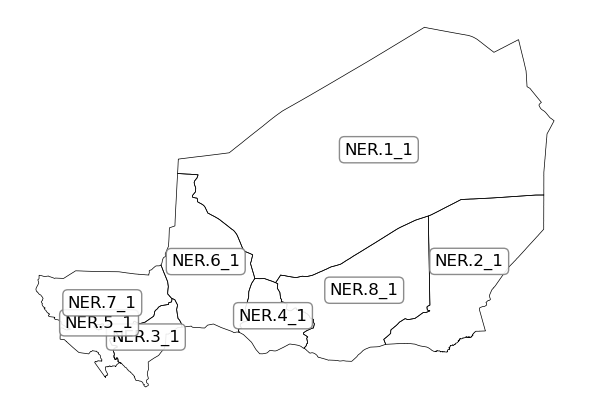

In [14]:
## Show GID_1 Regions in Niger
fn.plotLocations(path_to_regions, plotLocNames=True, indexColumn="GID_1")

#### 1) Wind Onshore installed capacity

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

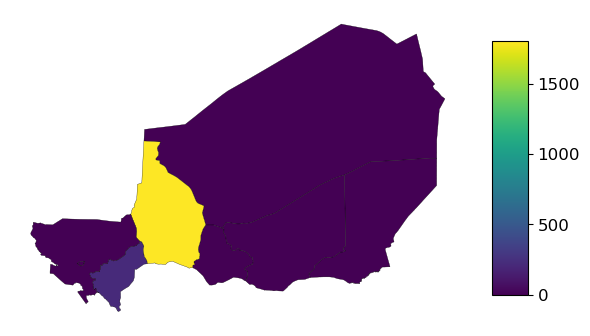

In [15]:
fn.plotLocationalColorMap(
    esM, "Onshore", path_to_regions, "GID_1", perArea=False
)

#### 2. PV installed capacity

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

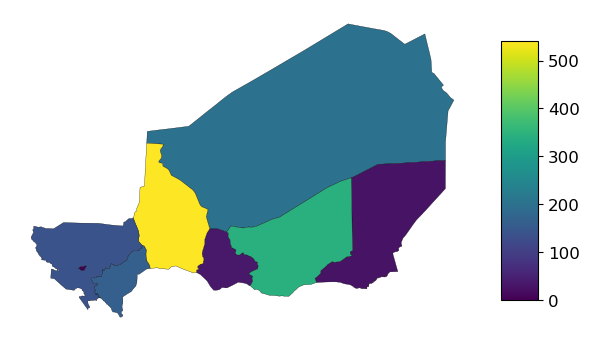

In [16]:
fn.plotLocationalColorMap(
    esM, "PV", path_to_regions, "GID_1", perArea=False
)

#### 3. Electricity demand

(<Figure size 1200x400 with 2 Axes>,
 <AxesSubplot:xlabel='period', ylabel='timestep per period'>)

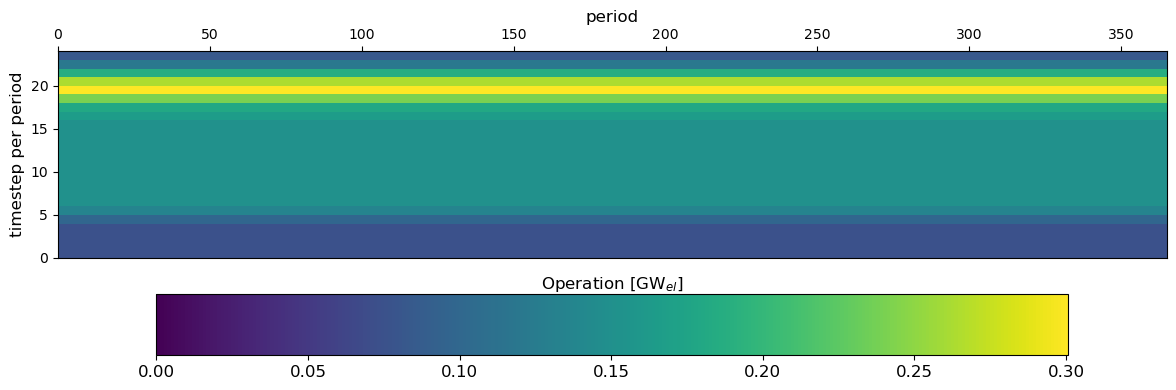

In [17]:
fn.plotOperationColorMap(esM, "electricity_demand", "NER.8_1")

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:xlabel='time step', ylabel='operation time series'>)

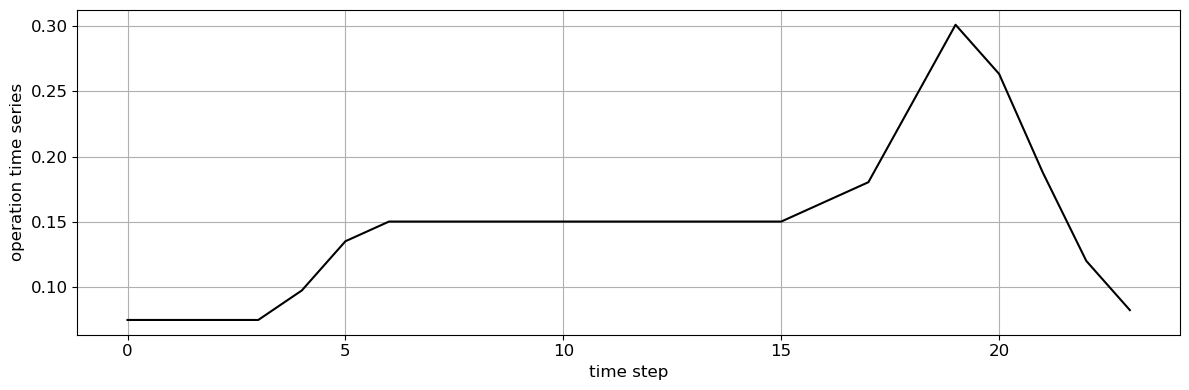

In [19]:
fn.plotOperation(esM, "electricity_demand", "NER.8_1",tMax=24)